Using the same model from Project 1 customize it. Customize (loss function, activaction function,metrics, layers, models (at least 2 of them))


In [1]:
# The dataset must first be imported 

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tarfile
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf

def load_car_data():
    df = pd.read_csv("car_price_dataset.csv")  
    return df  # Ensure the function returns the DataFrame

# assigned car_data as the call
car_data = load_car_data() 


In [2]:
# Verify the dataset is imported correctly
# Check for missing values
print("Missing values:\n", car_data.isnull().sum())

# Drop rows with missing values
car_data.dropna(inplace=True)

# Display the first 5 rows
print(car_data.head())

Missing values:
 Brand           0
Model           0
Year            0
Engine_Size     0
Fuel_Type       0
Transmission    0
Mileage         0
Doors           0
Owner_Count     0
Price           0
dtype: int64
        Brand   Model  Year  Engine_Size Fuel_Type    Transmission  Mileage  \
0         Kia     Rio  2020          4.2    Diesel          Manual   289944   
1   Chevrolet  Malibu  2012          2.0    Hybrid       Automatic     5356   
2    Mercedes     GLA  2020          4.2    Diesel       Automatic   231440   
3        Audi      Q5  2023          2.0  Electric          Manual   160971   
4  Volkswagen    Golf  2003          2.6    Hybrid  Semi-Automatic   286618   

   Doors  Owner_Count  Price  
0      3            5   8501  
1      2            3  12092  
2      4            2  11171  
3      2            1  11780  
4      3            3   2867  


In [3]:
# Compute the correlation matrix
corr_matrix = car_data.corr(numeric_only=True)
# Display correlation values sorted by 'Price'
print(corr_matrix["Price"].sort_values(ascending=False))
print(car_data.columns)

Price          1.000000
Year           0.663036
Engine_Size    0.357403
Owner_Count    0.002656
Doors          0.000511
Mileage       -0.551227
Name: Price, dtype: float64
Index(['Brand', 'Model', 'Year', 'Engine_Size', 'Fuel_Type', 'Transmission',
       'Mileage', 'Doors', 'Owner_Count', 'Price'],
      dtype='object')


In [4]:
# Scatter matrix for selected attributes including encoded categorical ones
# Map categorical features to numerical values
brand_mapping = {brand: idx for idx, brand in enumerate(car_data["Brand"].unique())}
fuel_mapping = {"Petrol": 0, "Diesel": 1, "Hybrid": 2, "Electric": 3}
transmission_mapping = {"Manual": 0, "Semi-Automatic": 1, "Automatic": 2}
model_segment_mapping = {
    "Rio": "Hatchback", "Malibu": "Sedan", "GLA": "SUV", "Q5": "SUV", "Golf": "Hatchback"
}

# Apply mappings
car_data["Brand_Group"] = car_data["Brand"].map(brand_mapping)
car_data["Fuel_Type"] = car_data["Fuel_Type"].map(fuel_mapping)
car_data["Transmission"] = car_data["Transmission"].map(transmission_mapping)
car_data["Car_Segment"] = car_data["Model"].map(model_segment_mapping).astype("category").cat.codes  # Convert segment to numerical

# Create Age of Car and Mileage per Year
current_year = 2025
car_data["Age_of_Car"] = current_year - car_data["Year"]
car_data["Mileage_per_Year"] = car_data["Mileage"] / car_data["Age_of_Car"]
car_data["Mileage_Impact"] = car_data["Mileage_per_Year"] * car_data["Age_of_Car"]
car_data["Engine_Fuel_Interaction"] = car_data["Engine_Size"] * car_data["Fuel_Type"]
car_data["Transmission_Engine_Interaction"] = car_data["Transmission"] * car_data["Engine_Size"]

# added for better correlations
car_data["Price_per_Engine_Size"] = car_data["Price"] / car_data["Engine_Size"]
car_data["Price_Age_Ratio"] = car_data["Price"] / car_data["Age_of_Car"]
car_data["Depreciation_Rate"] = car_data["Price"] / (car_data["Age_of_Car"] + 1)
car_data["Price_per_Mile"] = car_data["Price"] / (car_data["Mileage"] + 1)
car_data["Condition_Index"] = (car_data["Age_of_Car"] * 0.5) + (car_data["Mileage_per_Year"] * 0.3) + (car_data["Owner_Count"] * 0.2)
car_data["Engine_Age_Interaction"] = car_data["Engine_Size"] * car_data["Age_of_Car"]
car_data["Mileage_Age_Interaction"] = car_data["Mileage_per_Year"] * car_data["Age_of_Car"]
car_data["Engine_Mileage_Interaction"] = car_data["Engine_Size"] * car_data["Mileage_per_Year"]



# to fix skewed data 
car_data["Log_Price"] = np.log1p(car_data["Price"])
car_data["Log_Mileage_per_Year"] = np.log1p(car_data["Mileage_per_Year"])



# Select features for scatter matrix
selected_features = ["Price","Log_Price", "Engine_Size", "Log_Mileage_per_Year", "Age_of_Car", 
                     "Owner_Count", "Doors", "Fuel_Type", "Transmission", 
                     "Brand_Group", "Car_Segment", "Price_per_Engine_Size",'Engine_Age_Interaction', 'Mileage_Age_Interaction' , 
                     "Price_Age_Ratio", "Mileage_Impact", 'Engine_Mileage_Interaction',
                     "Engine_Fuel_Interaction", "Transmission_Engine_Interaction",
                     "Depreciation_Rate", "Price_per_Mile", "Condition_Index"]

In [5]:
# This is just for a visual for correlations
import seaborn as sns
#sns.pairplot(car_data[selected_features])
#plt.show()

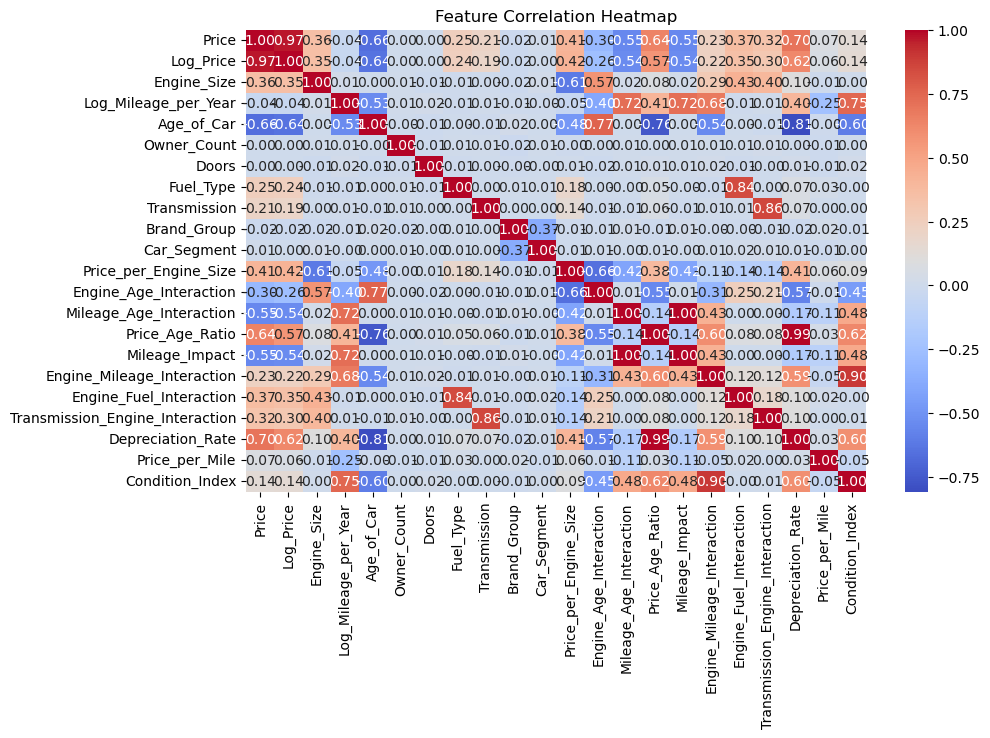

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(car_data[selected_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Clean the data

In [7]:
# handling numerical data is simple - since there are no null values
X_numerical = car_data.select_dtypes(include='number')

In [8]:

X_numerical.head()

,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price,Brand_Group,Car_Segment,...,Price_per_Engine_Size,Price_Age_Ratio,Depreciation_Rate,Price_per_Mile,Condition_Index,Engine_Age_Interaction,Mileage_Age_Interaction,Engine_Mileage_Interaction,Log_Price,Log_Mileage_per_Year
0,2020,4.2,1,0,289944,3,5,8501,0,0,...,2024.047619,1700.200000,1416.833333,0.029319,17400.140000,21.0,289944.0,243552.960000,9.048057,10.968022
1,2012,2.0,2,2,5356,2,3,12092,1,2,...,6046.000000,930.153846,863.714286,2.257234,130.700000,26.0,5356.0,824.000000,9.400382,6.023448
2,2020,4.2,1,2,231440,4,2,11171,2,1,...,2659.761905,2234.200000,1861.833333,0.048267,13889.300000,21.0,231440.0,194409.600000,9.321166,10.742660
3,2023,2.0,3,0,160971,2,1,11780,3,1,...,5890.000000,5890.000000,3926.666667,0.073180,24146.850000,4.0,160971.0,160971.000000,9.374243,11.295845
4,2003,2.6,2,1,286618,3,3,2867,4,0,...,1102.692308,130.318182,124.652174,0.010003,3920.027273,57.2,286618.0,33873.036364,7.961370,9.474940


In [9]:
X_numerical.drop(['Doors', 'Owner_Count', 'Price'], axis=1, inplace=True)

In [10]:
# now for the categorical stuff

In [11]:
oneHot = OneHotEncoder(sparse_output=False) # we set sparse_output=false to get back the proper array we want for ease of use

In [12]:
X_cats = car_data.select_dtypes(include='object') # select all the object data types in the dataset

In [13]:
X_cats_encoded = oneHot.fit_transform(X_cats) # encode them

In [14]:
X_cats = pd.DataFrame(X_cats_encoded, columns=oneHot.get_feature_names_out()) # create a dataframe of the encoded values
# and give the column names the names created by the one hot encoder using 'get_feature_names_out()'

In [15]:
X_cats.head() # for checking accuracy of encoding and looking at the new column names
# we also see that we are adding 47 columns this way. i believe there are other ways to handle the data

,Brand_Audi,Brand_BMW,Brand_Chevrolet,Brand_Ford,Brand_Honda,Brand_Hyundai,Brand_Kia,Brand_Mercedes,Brand_Toyota,Brand_Volkswagen,...,Model_Optima,Model_Passat,Model_Q5,Model_RAV4,Model_Rio,Model_Sonata,Model_Sportage,Model_Tiguan,Model_Tucson,Model_X5
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# now we add the encoded cats into the numerical dataset for the final 'cleaned' set
cleaned_df = pd.concat([X_numerical, X_cats], axis=1, sort=False)

In [17]:
cleaned_df.info() # look at all the new features/columns!!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 62 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Year                             10000 non-null  int64  
 1   Engine_Size                      10000 non-null  float64
 2   Fuel_Type                        10000 non-null  int64  
 3   Transmission                     10000 non-null  int64  
 4   Mileage                          10000 non-null  int64  
 5   Brand_Group                      10000 non-null  int64  
 6   Car_Segment                      10000 non-null  int8   
 7   Age_of_Car                       10000 non-null  int64  
 8   Mileage_per_Year                 10000 non-null  float64
 9   Mileage_Impact                   10000 non-null  float64
 10  Engine_Fuel_Interaction          10000 non-null  float64
 11  Transmission_Engine_Interaction  10000 non-null  float64
 12  Price_per_Engine_Si

In [18]:
cleaned_df.head(1)

,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Brand_Group,Car_Segment,Age_of_Car,Mileage_per_Year,Mileage_Impact,...,Model_Optima,Model_Passat,Model_Q5,Model_RAV4,Model_Rio,Model_Sonata,Model_Sportage,Model_Tiguan,Model_Tucson,Model_X5
0,2020,4.2,1,0,289944,0,0,5,57988.8,289944.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Training:

In [19]:
# Split into training (60%), validation (20%), and test (20%) sets
X = cleaned_df  # Features
y = car_data["Price"]  # Target variable

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 40% remains
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 50% of 40% = 20%

# Check dataset split sizes
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Training set size: (6000, 62)
Validation set size: (2000, 62)
Test set size: (2000, 62)


**Custom Activation Functions,Regularizers:**

In [20]:
def my_softplus(z):
    return tf.nn.softplus(z)

class myL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor=0.01):
        self.factor = factor

    def __call__(self, x):
        return tf.reduce_sum(tf.abs(self.factor * x))

    def get_config(self):
        # This is necessary to support serialization
        return {"factor": self.factor}
    

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
tf.random.set_seed(42) # because the model will also have hidden randomness in places but its better to set this before the trainTestSplit


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(62,)), 
    tf.keras.layers.Flatten(), 
    BatchNormalization(),
    Dropout(0.2),
    Dense(140, activation= my_softplus, kernel_initializer='he_normal', kernel_regularizer=myL1Regularizer),
    Dropout(0.2),
    Dense(120, activation= my_softplus, kernel_initializer='he_normal', kernel_regularizer=myL1Regularizer),
    Dropout(0.3),
    Dense(100, activation= my_softplus, kernel_initializer='he_normal', kernel_regularizer=myL1Regularizer),
    Dropout(0.2),
    Dense(80, activation= my_softplus, kernel_initializer='he_normal', kernel_regularizer=myL1Regularizer),
    Dense(40, activation= my_softplus, kernel_initializer='he_normal', kernel_regularizer=myL1Regularizer),
    Dense(20, activation= my_softplus, kernel_initializer='he_normal', kernel_regularizer=myL1Regularizer),
    Dense(1) 
]) 


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 62)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62)             │           248 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 140)            │         8,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        16,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        12,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 80)             │         8,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,249 (196.29 KB)

 Trainable params: 50,125 (195.80 KB)

 Non-trainable params: 124 (496.00 B)

**LOSS FUNCTION:**


In [48]:

def huber_fn(y_true, y_pred, threshold=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < threshold
    squared_loss = tf.square(error) / 2
    # Notice we now multiply by 'threshold' in the linear term:
    linear_loss = threshold * tf.abs(error) - threshold**2 / 2
    return tf.where(is_small_error, squared_loss, linear_loss)



In [49]:
model.compile(loss=huber_fn, optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['RootMeanSquaredError'])


In [56]:
from pathlib import Path
from time import strftime

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=64,
    callbacks=[tensorboard_cb]
)
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 1204.2344 - loss: 967.3422 - val_RootMeanSquaredError: 797.5064 - val_loss: 720.6479
Epoch 2/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 1235.1853 - loss: 987.8746 - val_RootMeanSquaredError: 873.0574 - val_loss: 790.1620
Epoch 3/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 1225.5576 - loss: 987.0380 - val_RootMeanSquaredError: 597.1367 - val_loss: 537.3061
Epoch 4/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 1215.3344 - loss: 976.2198 - val_RootMeanSquaredError: 851.6971 - val_loss: 779.1262
Epoch 5/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 1207.0070 - loss: 968.7271 - val_RootMeanSquaredError: 835.7647 - val_loss: 753.7241
Epoch 6/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 1215.8864 - loss: 977.7985 - val_RootMeanSquaredError: 583.2960 - val_loss: 529.6179
Epoch 7/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

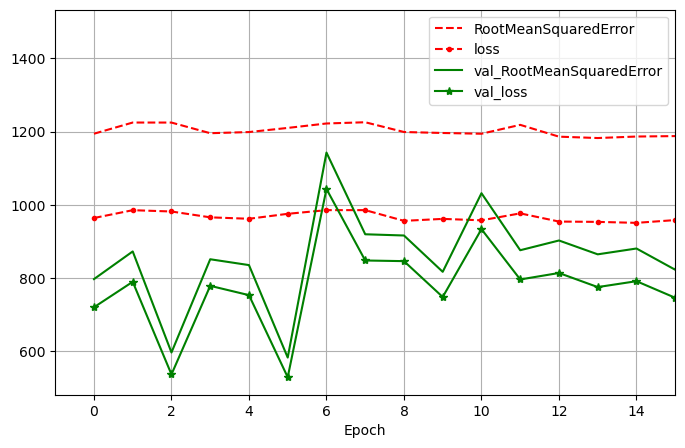

In [57]:

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[-1, 15], grid=True, xlabel="Epoch", 
    style=["r--", "r--.", "g-", "g-*"])
plt.show()

In [58]:
model.evaluate(X_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - RootMeanSquaredError: 1339.2249 - loss: 1218.5721


[1215.3814697265625, 1336.1370849609375]

In [59]:
X_new = cleaned_df[:5]

In [60]:
car_data.head(5)

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price,...,Price_per_Engine_Size,Price_Age_Ratio,Depreciation_Rate,Price_per_Mile,Condition_Index,Engine_Age_Interaction,Mileage_Age_Interaction,Engine_Mileage_Interaction,Log_Price,Log_Mileage_per_Year
0,Kia,Rio,2020,4.2,1,0,289944,3,5,8501,...,2024.047619,1700.200000,1416.833333,0.029319,17400.140000,21.0,289944.0,243552.960000,9.048057,10.968022
1,Chevrolet,Malibu,2012,2.0,2,2,5356,2,3,12092,...,6046.000000,930.153846,863.714286,2.257234,130.700000,26.0,5356.0,824.000000,9.400382,6.023448
2,Mercedes,GLA,2020,4.2,1,2,231440,4,2,11171,...,2659.761905,2234.200000,1861.833333,0.048267,13889.300000,21.0,231440.0,194409.600000,9.321166,10.742660
3,Audi,Q5,2023,2.0,3,0,160971,2,1,11780,...,5890.000000,5890.000000,3926.666667,0.073180,24146.850000,4.0,160971.0,160971.000000,9.374243,11.295845
4,Volkswagen,Golf,2003,2.6,2,1,286618,3,3,2867,...,1102.692308,130.318182,124.652174,0.010003,3920.027273,57.2,286618.0,33873.036364,7.961370,9.474940


In [61]:
model.predict(X_new).round(0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[ 7272.],
       [10265.],
       [ 9536.],
       [ 9751.],
       [ 3059.]], dtype=float32)